## Import necessary libraries

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [170]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [172]:
import plotly.express as px

## Data Cleaning Process

In [148]:
# Data Cleaning
# Load the dataset
df = pd.read_csv("predictive_maintenance.csv")
np.random.seed(0)

# 1. Drop UDI because it is not used and destroys model efficiency -------------------------------------
df.drop(columns=['UDI'], inplace=True)

# 2. Check for Missing Values ----------------------------------------
missing_values = df.isnull().sum()
if missing_values.sum() == 0:
    print("✅ No missing values found.")
else:
    print("⚠️ Missing values detected:\n", missing_values)

# 3. Encode Categorical Features -------------------------------------
# Alphabetically
label_enc = LabelEncoder()

# Encoding Product ID
df['Product ID'] = label_enc.fit_transform(df['Product ID'])

# Encoding Type and Failure Type
df['Type'] = label_enc.fit_transform(df['Type'])
# df['Failure Type'] = label_enc.fit_transform(df['Failure Type'])

# Define your custom mapping (No Failure first)
failure_mapping = {
    'No Failure': 0,
    'Heat Dissipation Failure': 1,
    'Overstrain Failure': 2,
    'Power Failure': 3,
    'Random Failures': 4,
    'Tool Wear Failure': 5
}

# Apply mapping
df['Failure Type'] = df['Failure Type'].map(failure_mapping)

# Verify
print(df['Failure Type'].value_counts().sort_index())
      
# 4. Standardizing Numerical Features -------------------------------
scaler = StandardScaler()

# 5. Final Data Check -----------------------------------------------
print("\n🔍 Final Data Check:")
print(df.info())

# Save cleaned data
df.to_csv("cleaned_data.csv", index=False)
print("\n✅ Cleaned data saved as 'cleaned_data.csv'.")

✅ No missing values found.
Failure Type
0    9652
1     112
2      78
3      95
4      18
5      45
Name: count, dtype: int64

🔍 Final Data Check:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  int32  
 1   Type                     10000 non-null  int32  
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Target                   10000 non-null  int64  
 8   Failure Type             10000 non-null  int64  
dtypes: float64(3), int32(2), int64(4)
memory usage: 625.1 KB
None

✅ Cleaned data saved as 'cleaned_data.csv'.


In [150]:
# Check for failure types, make sure to un-comment the code in the previous section first
print("Categories in order:", label_enc.classes_)

Categories in order: ['H' 'L' 'M']


## Data Preprocessing for Machine Learning
Prepares dataset for predictive modelling.

In [153]:
# Define features and target
X = df.drop(columns=['Target'])  # Features
y = df['Target']                 # Target label (0 = No Failure, 1 = Failure)

# Scale the features for models that are sensitive to feature scales (like SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 📌 For reference
    No Failure: 0
    Heat Dissipation Failure: 1
    Overstrain Failure: 2
    Power Failure: 3
    Random Failures: 4
    Tool Wear Failure: 5


## **Question 1:** How do different operational conditions, such as tool wear, temperature, and torque, influence the frequency and distribution of machine failure types, and how do these failure types vary across different product and machine types?

### Testing correlation between operational conditions and failure type

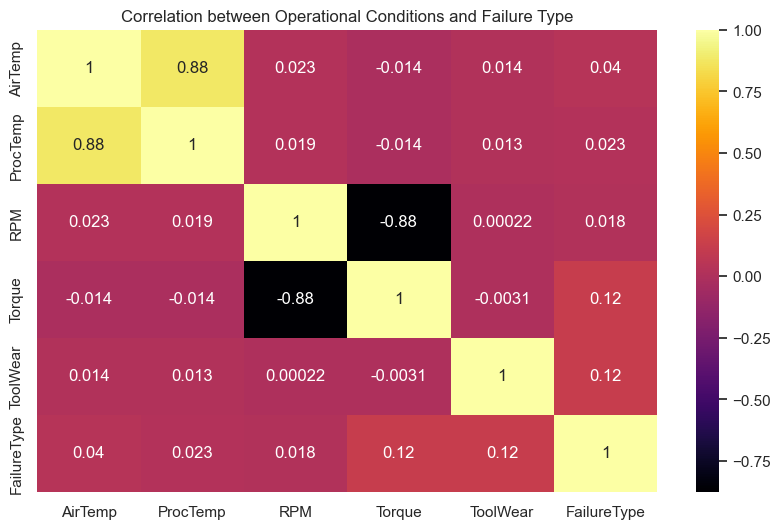

In [156]:
# Load the dataset
df = pd.read_csv("cleaned_data.csv")

# Rename columns for easier access
df.rename(columns={
    "Air temperature [K]": "AirTemp",
    "Process temperature [K]": "ProcTemp",
    "Rotational speed [rpm]": "RPM",
    "Torque [Nm]": "Torque",
    "Tool wear [min]": "ToolWear",
    "Failure Type": "FailureType",
    "Type": "MachineType"
}, inplace=True)

# Plot correlation heatmap between operational variables and failure type
plt.figure(figsize=(10, 6))
corr = df[['AirTemp', 'ProcTemp', 'RPM', 'Torque', 'ToolWear', 'FailureType']].corr()
sns.heatmap(corr, annot=True, cmap='inferno')
plt.title("Correlation between Operational Conditions and Failure Type")
plt.show()


### Boxplots: Failure Type vs Operational Variable

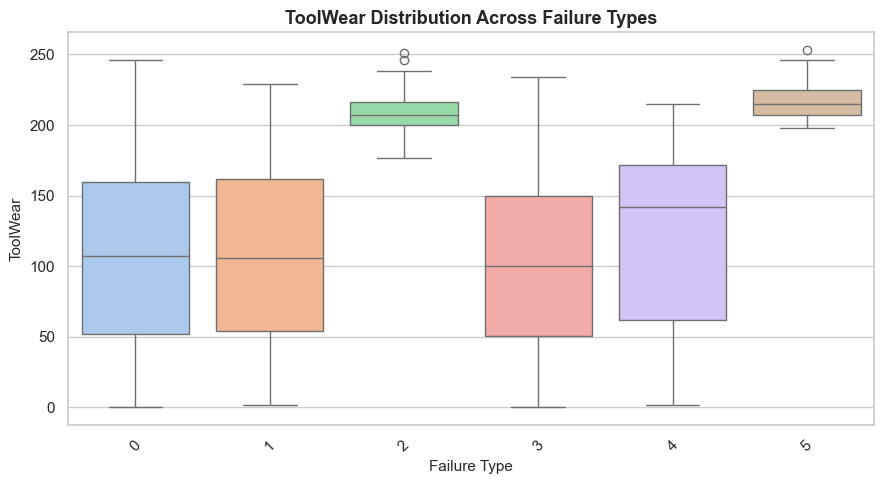

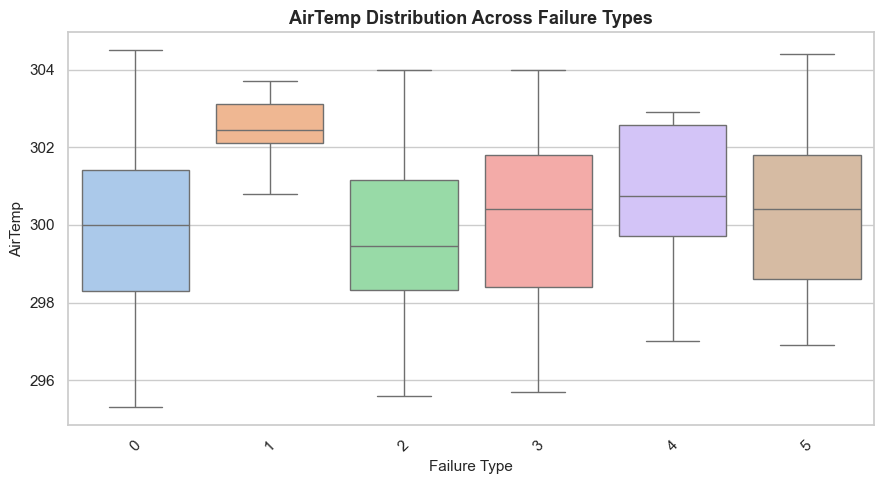

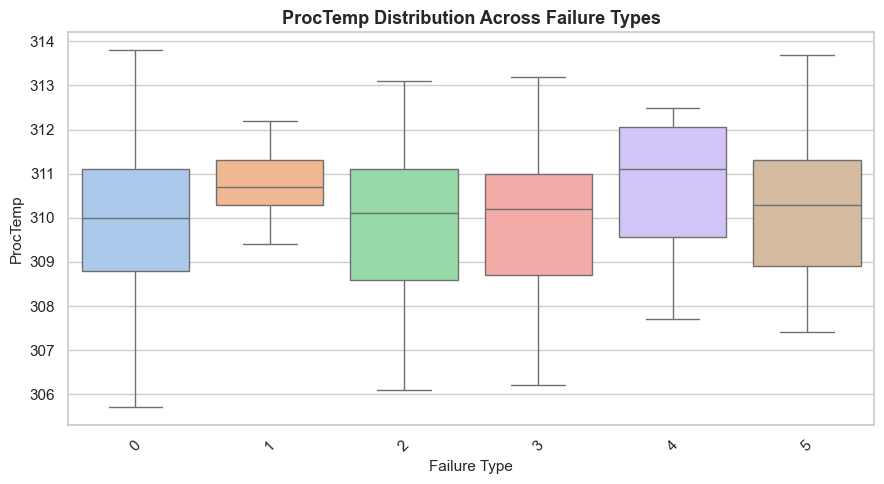

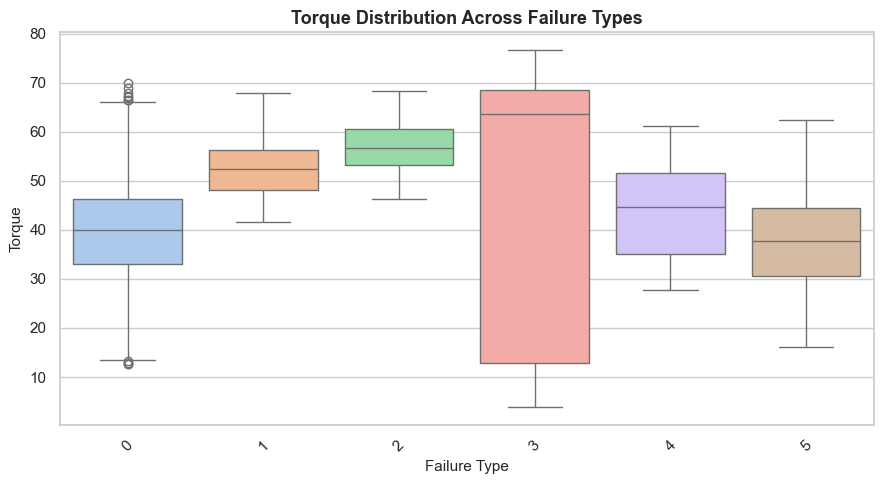

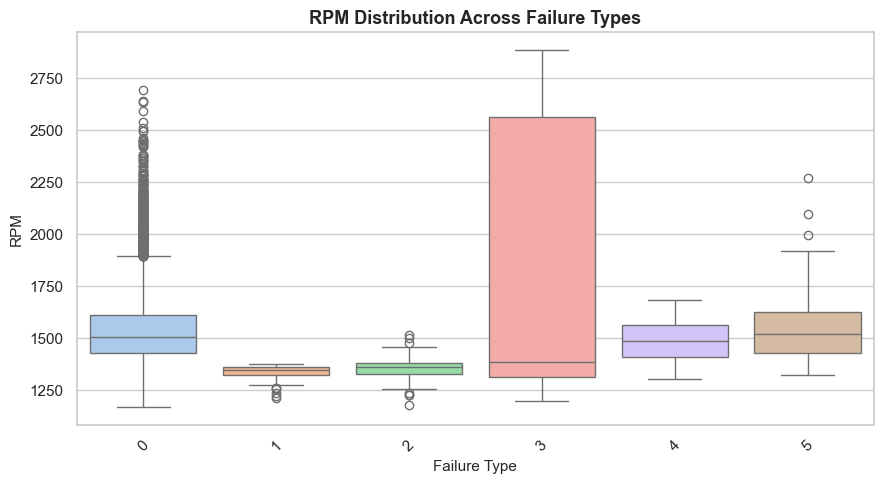

In [166]:
# --- Boxplots: Failure Type vs Operational Variables ---
for feature in ['ToolWear', 'AirTemp', 'ProcTemp', 'Torque', 'RPM']:
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x='FailureType', y=feature, hue='FailureType', palette="pastel", legend=False)
    plt.title(f"{feature} Distribution Across Failure Types", fontsize=13, weight='bold')
    plt.xlabel("Failure Type", fontsize=11)
    plt.ylabel(feature, fontsize=11)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Countplot: Machine Type vs Failure Type

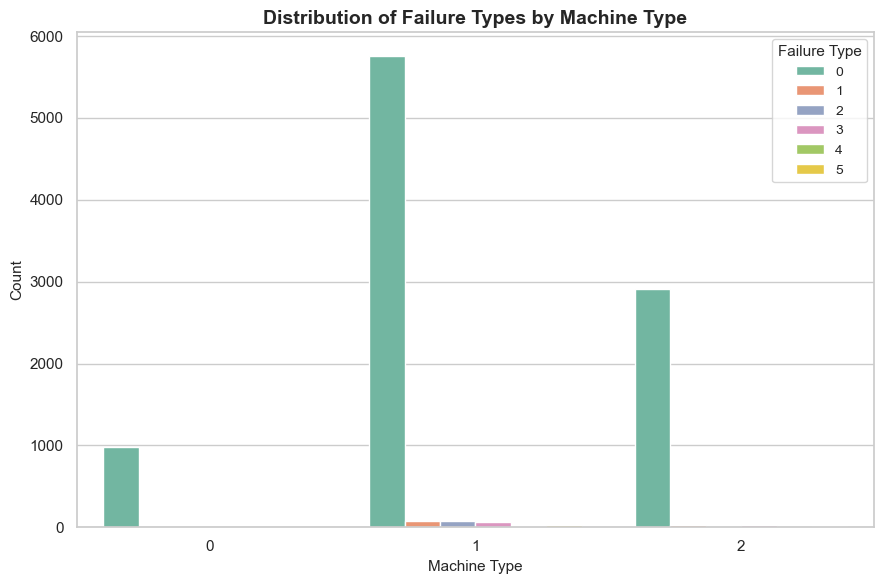

In [177]:
# --- Countplot: Machine Type vs Failure Type ---
plt.figure(figsize=(9, 6))
sns.countplot(data=df, x='MachineType', hue='FailureType', palette="Set2")
plt.title("Distribution of Failure Types by Machine Type", fontsize=14, weight='bold')
plt.xlabel("Machine Type", fontsize=11)
plt.ylabel("Count", fontsize=11)
plt.legend(title="Failure Type", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()

### Interactive visualization

#### With failure type being encoded

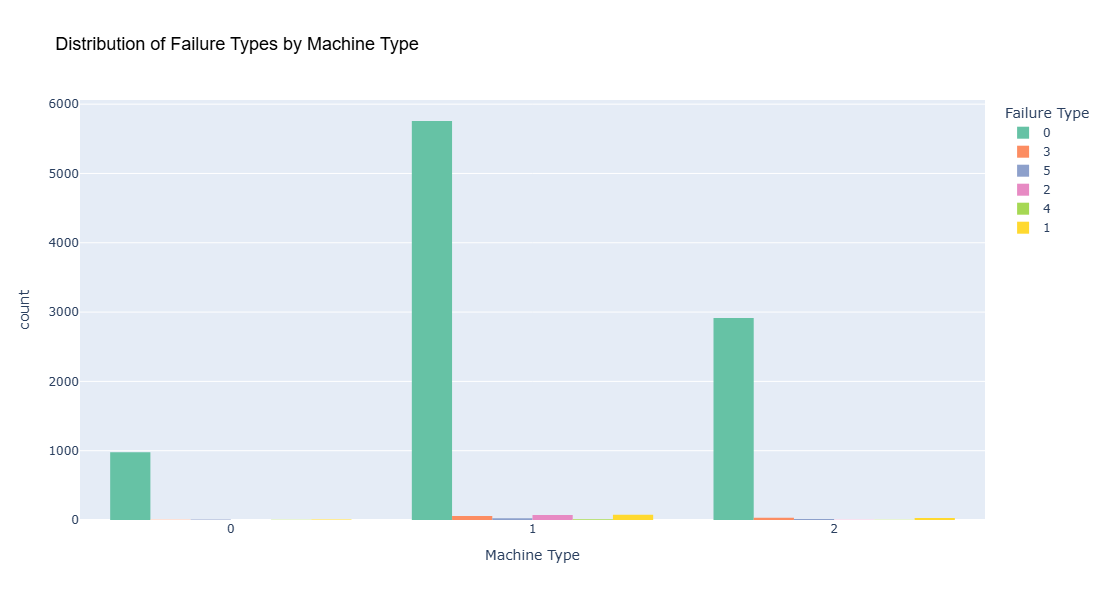

In [183]:
# Interactive Countplot: Machine Type vs Failure Type
fig = px.histogram(df, 
                   x='MachineType', 
                   color='FailureType',
                   barmode='group',
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   title="Distribution of Failure Types by Machine Type",
                   labels={'MachineType': 'Machine Type', 'count': 'Count'},
                   width=900, height=600)

fig.update_layout(
    title_font=dict(size=18, family='Arial', color='black'),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    legend_title_text='Failure Type',
    legend=dict(font=dict(size=12)),
    hovermode='x unified'
)

fig.show()

#### With proper failure type labeling instead of numbers

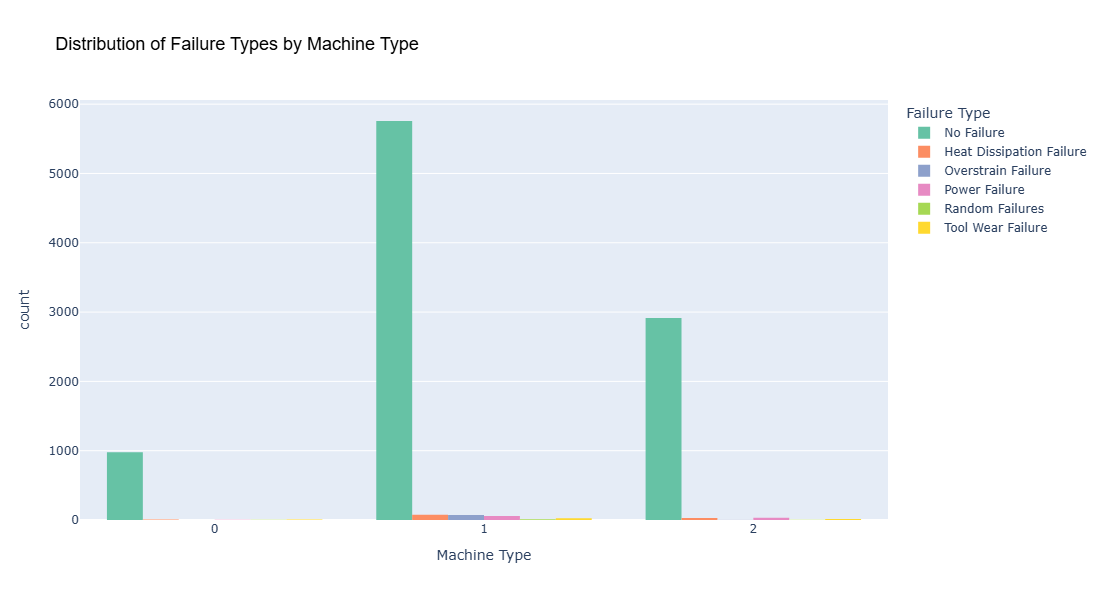

In [181]:
# Interactive Countplot: Machine Type vs Failure Type

import plotly.express as px

# Reverse your mapping to get names back
failure_name_mapping = {v: k for k, v in failure_mapping.items()}

# Create a temporary column with the failure names
df['FailureType_Name'] = df['FailureType'].map(failure_name_mapping)

# Interactive Countplot with proper labels
fig = px.histogram(df, 
                   x='MachineType',  # Using the correct column name from your DataFrame
                   color='FailureType_Name',
                   barmode='group',
                   color_discrete_sequence=px.colors.qualitative.Set2,
                   title="Distribution of Failure Types by Machine Type",
                   labels={'MachineType': 'Machine Type', 'count': 'Count', 'FailureType_Name': 'Failure Type'},
                   width=900, height=600,
                   category_orders={"FailureType_Name": list(failure_mapping.keys())})

fig.update_layout(
    title_font=dict(size=18, family='Arial', color='black'),
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14),
    legend_title_text='Failure Type',
    legend=dict(font=dict(size=12)),
    hovermode='x unified',
    hoverlabel=dict(font_size=12)
)

# Customize hover template
fig.update_traces(hovertemplate="<b>%{x}</b><br>Failure Type: %{fullData.name}<br>Count: %{y}<extra></extra>")

fig.show()

In [205]:
from scipy.stats import f_oneway

for feature in features:
    groups = [df[df['FailureType'] == i][feature] for i in df['FailureType'].unique()]
    f_val, p_val = f_oneway(*groups)
    print(f'{feature}: F={f_val:.2f}, p={p_val:.4f}')


AirTemp: F=38.79, p=0.0000
ProcTemp: F=7.60, p=0.0000
RPM: F=78.21, p=0.0000
Torque: F=104.40, p=0.0000
ToolWear: F=68.19, p=0.0000


## **Question 2:** Does tool wear increase the likelihood of machine failure, and is there a critical threshold where failure risk spikes?

## **Question 3:** Can machine learning models (e.g., Random Forest, SVM, XGBoost) accurately predict machine failures based on real-time sensor data?

In [100]:
# Question 3 (Damia)

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Initialize and train the models

# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Machine
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [102]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate models using accuracy, precision, recall, and F1-score

# Create a function to extract model performance
def extract_performance(y_test, y_pred, model_name):
    report = classification_report(y_test, y_pred, output_dict=True)
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"]
    }

# Compile performance metrics
results = {
    "Random Forest": extract_performance(y_test, y_pred_rf, "Random Forest"),
    "SVM": extract_performance(y_test, y_pred_svm, "SVM"),
    "XGBoost": extract_performance(y_test, y_pred_xgb, "XGBoost")
}

# Display results
pd.DataFrame(results).T

,Accuracy,Precision,Recall,F1-Score
Random Forest,0.9975,0.951613,0.967213,0.959350
SVM,0.9980,0.967213,0.967213,0.967213
XGBoost,0.9990,1.000000,0.967213,0.983333


## **Question 4:** What are optimal maintenance thresholds for key sensors (e.g., "Intervene if Tool wear > 90%") to balance cost and downtime?

C:\Users\Gracie\AppData\Local\Temp\ipykernel_10780\3839834006.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  threshold_analysis = df.groupby('Tool wear bin')['Target'].mean().reset_index()
C:\Users\Gracie\AppData\Local\Temp\ipykernel_10780\3839834006.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Tool Wear Range', y='Failure Rate', data=threshold_analysis, palette="rocket")


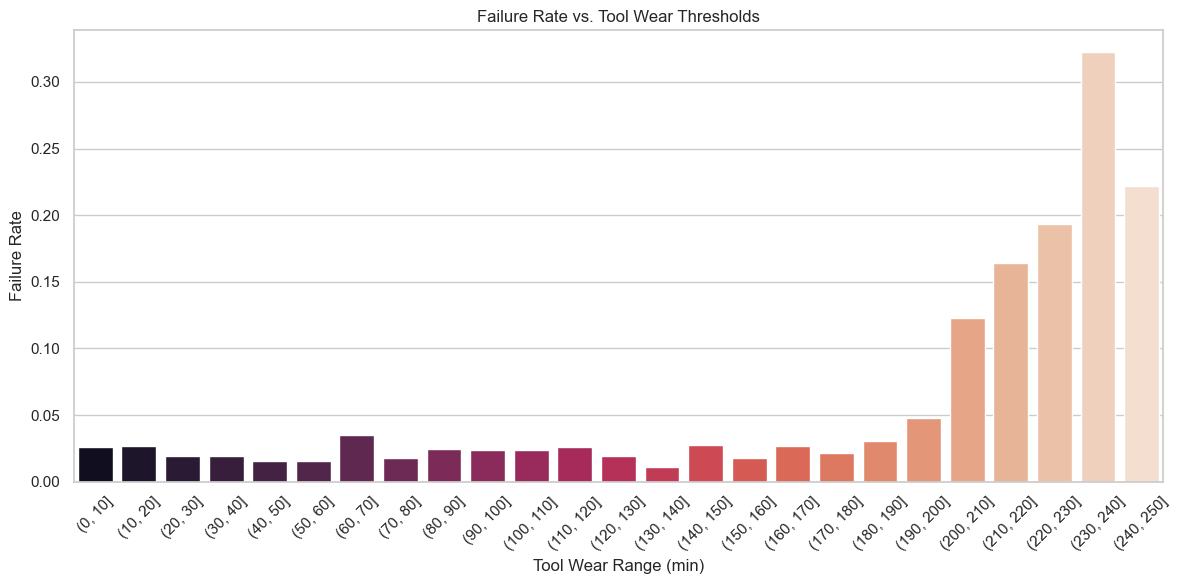

   Tool Wear Range  Failure Rate
0          (0, 10]      0.025882
1         (10, 20]      0.027140
2         (20, 30]      0.019651
3         (30, 40]      0.019608
4         (40, 50]      0.015385
5         (50, 60]      0.015385
6         (60, 70]      0.035011
7         (70, 80]      0.017505
8         (80, 90]      0.024609
9        (90, 100]      0.024176
10      (100, 110]      0.024176
11      (110, 120]      0.025751
12      (120, 130]      0.019608
13      (130, 140]      0.011161
14      (140, 150]      0.027837
15      (150, 160]      0.017778
16      (160, 170]      0.027149
17      (170, 180]      0.021368
18      (180, 190]      0.030769
19      (190, 200]      0.047722
20      (200, 210]      0.122850
21      (210, 220]      0.164444
22      (220, 230]      0.193182
23      (230, 240]      0.322581
24      (240, 250]      0.222222


In [105]:
# Question 4 (Lycia)

# Load the cleaned dataset
df = pd.read_csv("cleaned_data.csv")  # Make sure this path is correct in your notebook

# Step 1: Create bins for tool wear
df['Tool wear bin'] = pd.cut(df['Tool wear [min]'], bins=np.arange(0, 260, 10))

# Step 2: Calculate failure rate per bin
threshold_analysis = df.groupby('Tool wear bin')['Target'].mean().reset_index()
threshold_analysis.columns = ['Tool Wear Range', 'Failure Rate']

# Step 3: Plot failure rate vs. tool wear range
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='Tool Wear Range', y='Failure Rate', data=threshold_analysis, palette="rocket")

# Step 4: Final plot adjustments
plt.xticks(rotation=45)
plt.title("Failure Rate vs. Tool Wear Thresholds")
plt.xlabel("Tool Wear Range (min)")
plt.ylabel("Failure Rate")
plt.tight_layout()
plt.show()

# Optional: Display the table of results
print(threshold_analysis)

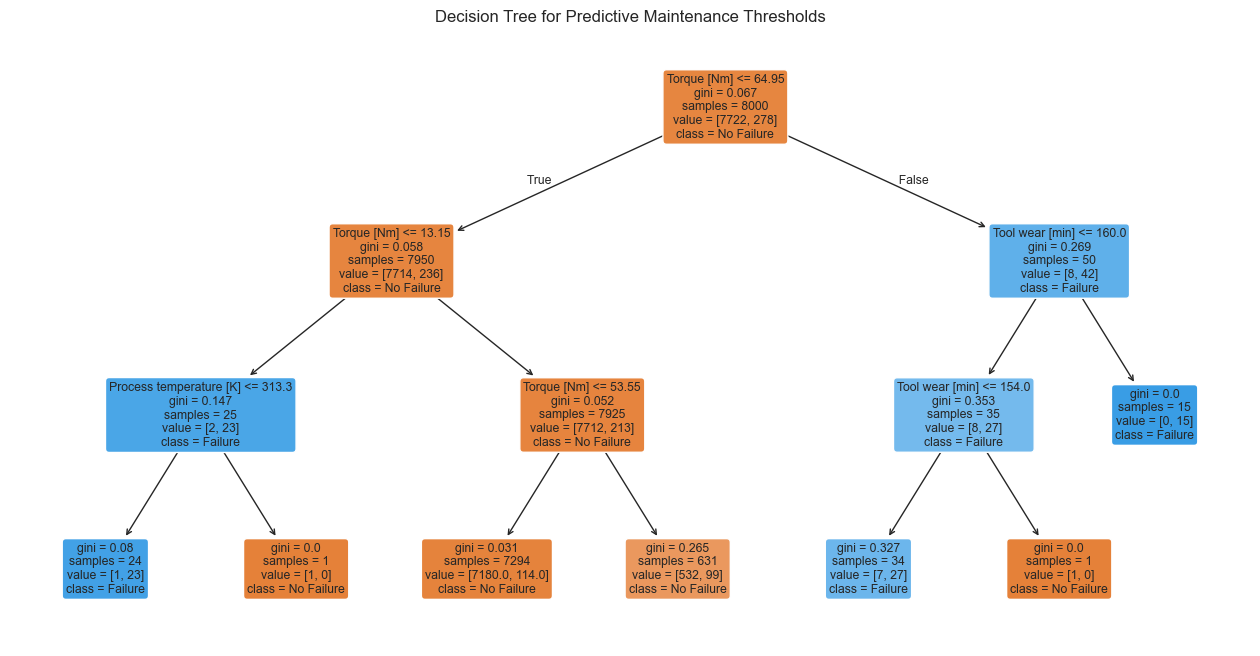

              precision    recall  f1-score   support

  No Failure       0.98      1.00      0.99      1939
     Failure       0.79      0.25      0.38        61

    accuracy                           0.97      2000
   macro avg       0.88      0.62      0.68      2000
weighted avg       0.97      0.97      0.97      2000



In [107]:
# Select key sensor features and target
features = ['Tool wear [min]', 'Torque [Nm]', 'Air temperature [K]', 'Process temperature [K]']
X = df[features]
y = df['Target']

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

# Step 3: Plot the decision tree
plt.figure(figsize=(16, 8))
plot_tree(tree_model, feature_names=features, class_names=["No Failure", "Failure"],
          filled=True, rounded=True)
plt.title("Decision Tree for Predictive Maintenance Thresholds")
plt.show()

# Step 4: Classification performance
y_pred = tree_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=["No Failure", "Failure"])
print(report)